# Detecting programming languages with CNNs
This notebook contains an implementations of different CNNs for detecting
programming languages from source code.
The initial code was copied from https://github.com/IBM/Project_CodeNet/blob/main/notebooks/Project_CodeNet_LangClass.ipynb
and restructured. Further, some different CNN architectures were evaluated.
The sample data set is available on https://developer.ibm.com/exchanges/data/all/project-codenet/
(Project_CodeNet_LangClass.tar.gz).

In [2]:
%load_ext autoreload
%autoreload 2

## Data preprocessing
The cell below uses the functionality provided in ./preProcessUtil to
pre-process the training data set.

The pre-processing includes following steps:
1. Each source file is broken up into three parts.
2. Each character in these parts is one-hot encoded and stored in a vector with default length 1024 (truncated or padded).
3. The labels are inferred from the directory structure.
4. Finally, the data set is shuffled.

In [3]:
from src.preProcessUtils import *

DATA_SET_PATH = "C:/Users/sebas/Documents/Masterarbeit/datasets/LangClass"
x, y, files = get_input_and_labels(root_folder=f'{DATA_SET_PATH}/train')

# Shuffle data
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

print('samples shape', x_shuffled.shape)
print('class labels shape:', y_shuffled.shape)


Processing language: C
Processing language: C#
Processing language: C++
Processing language: D
Processing language: Haskell
Processing language: Java
Processing language: JavaScript
Processing language: PHP
Processing language: Python
Processing language: Rust
samples shape (2098, 1024, 68)
class labels shape: (2098, 10)


## Model
The model architecture consists of three parallel convolutional layers each
followed by a max-pooling layer of the same size.
The output of these parallel layers are concatenated and followed by
a fully connected layer (128 units, ReLu), followed by a drop-out layer (prob=0.5),
followed by final dense layer (10 units, softmax).

In [4]:
from keras.utils.vis_utils import plot_model
from src.model import create_model

model = create_model()
model.summary()
plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 68)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1022, 128)    26240       ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1016, 128)    78464       ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1006, 128)    165504      ['input_1[0][0]']                
                                                                                              

## Training
Parameters:
- Batch size: 64
- Nr. of epochs: 20
- Validation split: 0.1

Epoch 1/20
30/30 [==============================] - 8s 226ms/step - loss: 2.5088 - accuracy: 0.2225 - precision: 0.1978 - recall: 0.0421 - val_loss: 1.8926 - val_accuracy: 0.3571 - val_precision: 0.4075 - val_recall: 0.0591

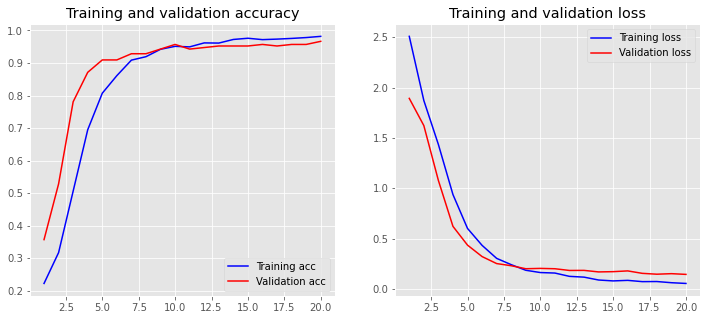

In [5]:
from src.model import train_model
from src.plot import plot_history
history = train_model(model, x_shuffled, y_shuffled)
plot_history(history)

## Evaluation
The model is evaluated with the test data set and evaluated considering
metrics like: Accuracy, Precision, Recall and F1 score.
For better visualization a confusion matrix is printed.

Processing language: C
Processing language: C#
Processing language: C++
Processing language: D
Processing language: Haskell
Processing language: Java
Processing language: JavaScript
Processing language: PHP
Processing language: Python
Processing language: Rust
shape of test samples (100, 1024, 68)
4/4 [==============================] - 0s 26ms/step - loss: 0.0692 - accuracy: 0.9800 - precision: 0.9670 - recall: 0.7797
-------- Metrics --------
Accuracy: 0.9800000190734863
Precision: 0.966978907585144
Recall: 0.7796584367752075
-------- Metrics per class --------
-------- C --------
TP=10, FP=0, FN=0
Precision: 1.0, Recall: 1.0, F1 score: 1.0
-------- C# --------
TP=10, FP=0, FN=0
Precision: 1.0, Recall: 1.0, F1 score: 1.0
-------- C++ --------
TP=9, FP=0, FN=1


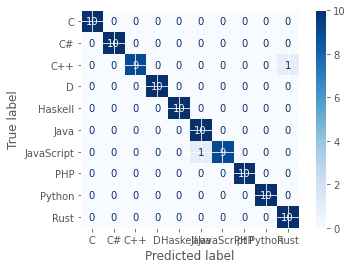

-------- Miss classified files --------
C:/Users/sebas/Documents/Masterarbeit/datasets/LangClass/test\C++\s022643156.cpp predicted as Rust
C:/Users/sebas/Documents/Masterarbeit/datasets/LangClass/test\JavaScript\s015429520.js predicted as Java


In [10]:
from src.model import eval_model
eval_model(model, f'{DATA_SET_PATH}/test')

## Experiments
As the original model is rather complex (~8 million parameters)
the goal of the experiments is to find a simple model with comparable
performance.
### Experiment #1
In the first experiment the parallel architecture of the original
model is transformed to a sequential architecture.

In [23]:
from src.model import create_model_experiment_1
model1 = create_model_experiment_1()
model1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 1016, 128)         78464     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 112, 128)         0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 14336)             0         
                                                                 
 dense_22 (Dense)            (None, 128)               1835136   
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 10)                1290      
                                                     

Epoch 1/20
30/30 [==============================] - 3s 98ms/step - loss: 2.2246 - accuracy: 0.2055 - precision_6: 0.3495 - recall_6: 0.0151 - val_loss: 1.9060 - val_accuracy: 0.3238 - val_precision_6: 0.7303 - val_recall_6: 0.0360

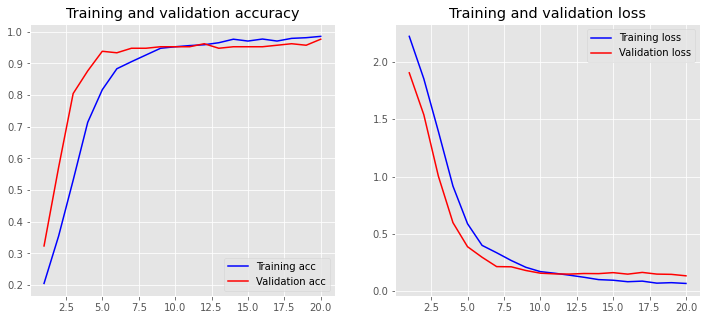

In [24]:
history = train_model(model1, x_shuffled, y_shuffled)
plot_history(history)

### Experiment #2
Reduce number of filters

In [26]:
from src.model import create_model_experiment_2
model2 = create_model_experiment_2()
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 1016, 64)          39232     
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 112, 64)          0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 7168)              0         
                                                                 
 dense_24 (Dense)            (None, 128)               917632    
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                1290      
                                                     

Epoch 1/20
30/30 [==============================] - 2s 65ms/step - loss: 2.2824 - accuracy: 0.1684 - precision_7: 0.2010 - recall_7: 0.0023 - val_loss: 2.0791 - val_accuracy: 0.2905 - val_precision_7: 0.6506 - val_recall_7: 0.0092

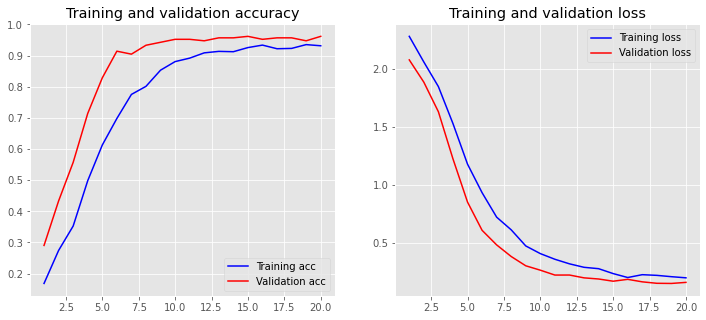

In [27]:
history = train_model(model2, x_shuffled, y_shuffled)
plot_history(history)

### Experiment #3
Reduce number of hidden units

In [32]:
from src.model import create_model_experiment_3
model3 = create_model_experiment_3()
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 1016, 64)          39232     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 112, 64)          0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 7168)              0         
                                                                 
 dense_28 (Dense)            (None, 64)                458816    
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 10)                650       
                                                     

Epoch 1/20
30/30 [==============================] - 2s 62ms/step - loss: 2.2260 - accuracy: 0.1886 - precision_9: 0.3667 - recall_9: 0.0025 - val_loss: 1.9705 - val_accuracy: 0.3095 - val_precision_9: 1.0000 - val_recall_9: 0.0179

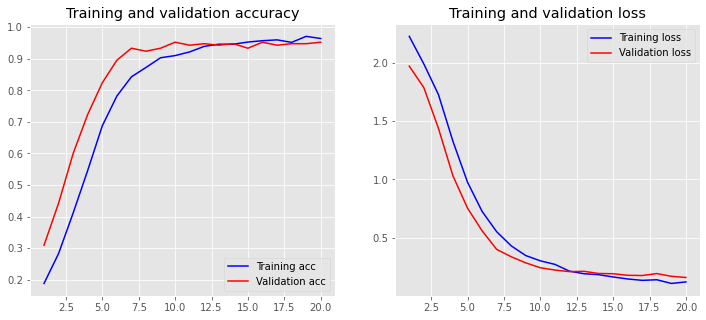

In [33]:
history = train_model(model3, x_shuffled, y_shuffled)
plot_history(history)

### Evaluation of the best model
Even the third and most simple model results in a similar validation
accuracy as the original model. This is impressive when we consider
the difference in the number of parameters (~8 million vs 500k).
Therefore, we evaluate it on our test set.

Processing language: C
Processing language: C#
Processing language: C++
Processing language: D
Processing language: Haskell
Processing language: Java
Processing language: JavaScript
Processing language: PHP
Processing language: Python
Processing language: Rust
shape of test samples (100, 1024, 68)
4/4 [==============================] - 0s 11ms/step - loss: 0.0362 - accuracy: 0.9800 - precision_8: 0.9640 - recall_8: 0.6779
-------- Metrics --------
Accuracy: 0.9800000190734863
Precision: 0.9640036225318909
Recall: 0.6778889298439026
-------- Metrics per class --------
-------- C --------
TP=10, FP=0, FN=0
Precision: 1.0, Recall: 1.0, F1 score: 1.0
-------- C# --------
TP=10, FP=0, FN=0
Precision: 1.0, Recall: 1.0, F1 score: 1.0
-------- C++ --------
TP=9, FP=0, FN=1
Precision: 1.0, Recall: 0.9, F1 score: 0.9473684210526316
-------- D --------
TP=10, FP=0, FN=0
Precision: 1

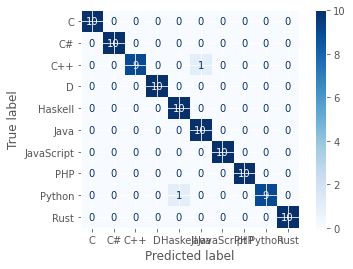

-------- Miss classified files --------
C:/Users/sebas/Documents/Masterarbeit/datasets/LangClass/test\C++\s022643156.cpp predicted as Java
C:/Users/sebas/Documents/Masterarbeit/datasets/LangClass/test\Python\s062554847.py predicted as Haskell


In [34]:
eval_model(model, f'{DATA_SET_PATH}/test')